In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import xarray as xr

from osu_util import read_osu_log, read_osu_log_multi, plot_osu

# Read logs

In [2]:
ls osu_log/bcast/

N16n576/  N1n36/    N2n72/    N32n1152/ N4n144/   N8n288/


In [3]:
ls osu_log_pleiades/bcast/

N12n288/  N1n24/    N24n576/  N3n72/    N48n1152/ N6n144/


In [4]:
ls osu_log/allreduce/

N16n576/  N1n36/    N2n72/    N32n1152/ N4n144/   N8n288/


In [5]:
ls osu_log_pleiades/allreduce/

N12n288/  N1n24/    N24n576/  N3n72/    N48n1152/ N6n144/


In [6]:
def read_scaling(suffix, prefix='./osu_log/bcast/', nas=False):
    
    # skip the first 24/36 core case where two platforms are not comparable
    if nas:
        N_list = [3, 6, 12, 24, 48]
        n_per_node = 24
    else:
        N_list = [2, 4, 8, 16, 32]
        n_per_node = 36
    
    file_list = [prefix + 'N{0}n{1}'.format(N, N*n_per_node) + suffix for N in N_list]
    df = read_osu_log_multi(file_list, [N*n_per_node for N in N_list])
    return df

In [7]:
def read_all_runs(case='bcast'):
    all_runs = []

    for run in range(1, 6):
        RUNDIR = '/run{}/'.format(run)
        
        prefix_aws = f'./osu_log/{case}/'
        df_impi_efa = read_scaling(RUNDIR + f'intelmpi-efa/{case}_default.log', prefix=prefix_aws)
        df_impi_tcp = read_scaling(RUNDIR + f'intelmpi-tcp/{case}_default.log', prefix=prefix_aws)
        df_ompi = read_scaling(RUNDIR + f'openmpi3/{case}_default.log', prefix=prefix_aws)
        df_nas = read_scaling(RUNDIR + f'{case}.log', prefix=f'./osu_log_pleiades/{case}/', nas=True)
        all_mpi = np.stack([df_impi_efa, df_impi_tcp, df_ompi, df_nas])

        all_runs.append(all_mpi)

    all_runs = np.stack(all_runs)
    print(all_runs.shape)  # (run, mpi, message size, cores)
    
    dr = xr.DataArray(
        all_runs, dims=('run', 'mpi', 'message', 'cores'), 
        coords={'mpi': ['IntelMPI-EFA', 'IntelMPI-TCP', 'OpenMPI-TCP', 'Pleiades'],
                'message': df_impi_efa.index.values,
                'run': range(1, 6),
                'cores': [72, 144, 288, 576, 1152]
               }
    )
    print(dr.sizes)
    
    return dr

In [8]:
dr = read_all_runs()

(5, 4, 21, 5)
Frozen(OrderedDict([('run', 5), ('mpi', 4), ('message', 21), ('cores', 5)]))


In [9]:
dr_ad = read_all_runs('allreduce')

(5, 4, 19, 5)
Frozen(OrderedDict([('run', 5), ('mpi', 4), ('message', 19), ('cores', 5)]))


# Quick plots

## Bcast

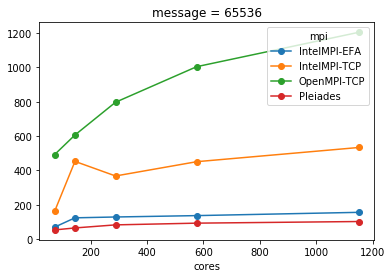

In [10]:
dr.sel(message=65536).mean(dim='run').plot(hue='mpi', marker='o');

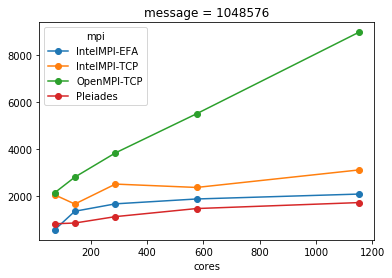

In [11]:
dr.isel(message=-1).mean(dim='run').plot(hue='mpi', marker='o');

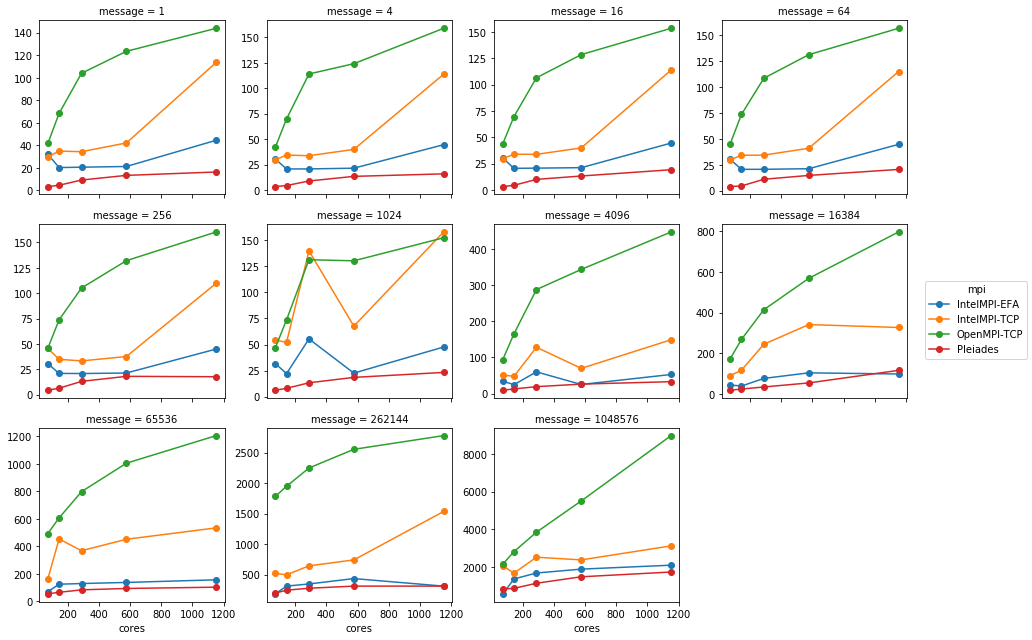

In [12]:
(dr.isel(message=range(0, 22, 2))
 .mean(dim='run')
 .plot(hue='mpi', col='message', col_wrap=4, 
       marker='o', sharey=False)
);

Text(479.8823529411765, 0.5, 'Time (us)')

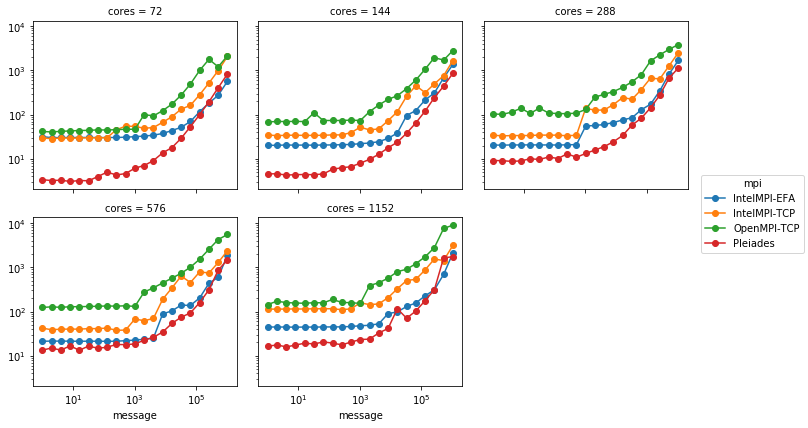

In [13]:
dr.mean(dim='run').plot(col='cores', hue='mpi', marker='o', col_wrap=3, sharey=True)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Time (us)')

## Allreduce

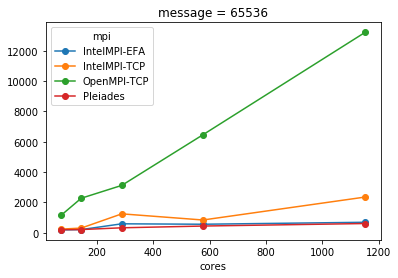

In [14]:
dr_ad.sel(message=65536).mean(dim='run').plot(hue='mpi', marker='o');

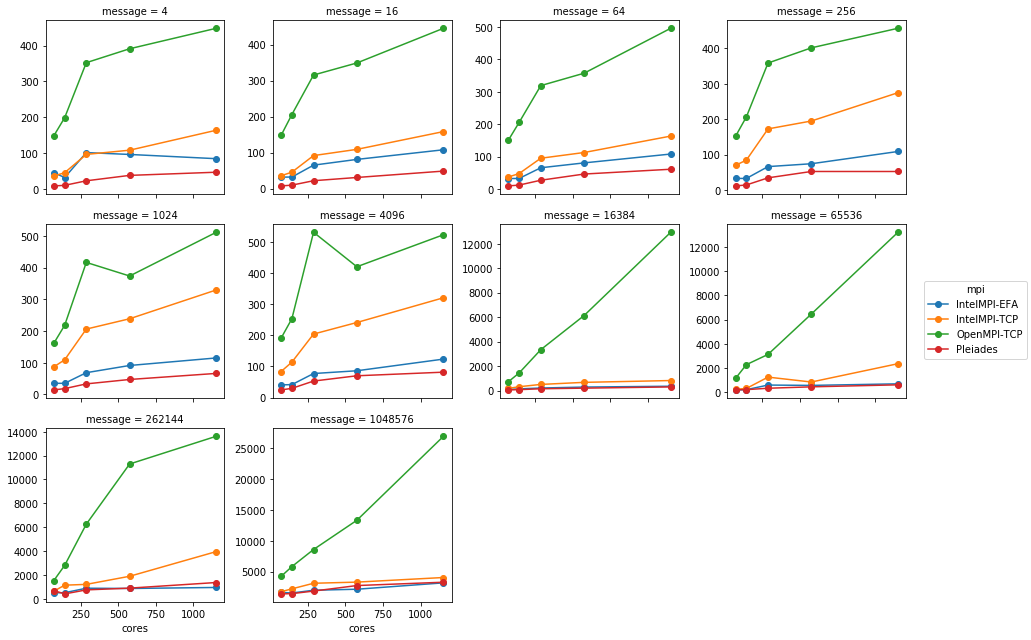

In [15]:
(dr_ad.isel(message=range(0, 20, 2))
 .mean(dim='run')
 .plot(hue='mpi', col='message', col_wrap=4, 
       marker='o', sharey=False)
);

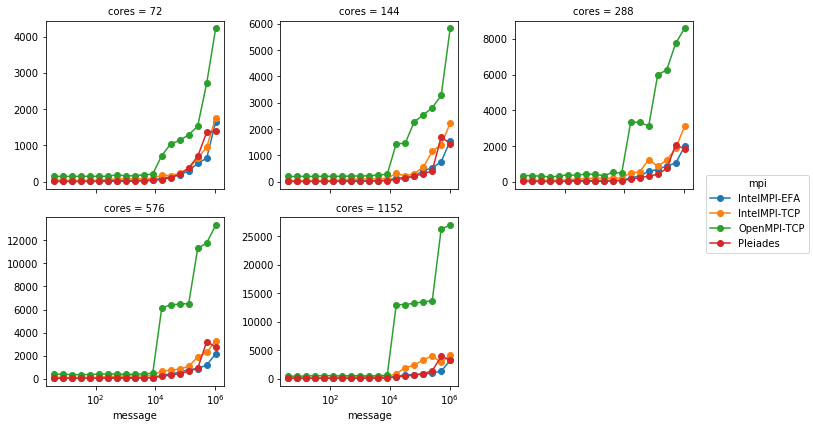

In [16]:
dr_ad.mean(dim='run').plot(col='cores', hue='mpi', marker='o', col_wrap=3, sharey=False)
plt.xscale('log')

# Extract important dataframe

In [17]:
# scaling with cores
# only select the largest message size
df_cores = dr.sel(message=1048576).min(dim='run').to_pandas().T
df_cores.columns.name = ''
df_cores

,IntelMPI-EFA,IntelMPI-TCP,OpenMPI-TCP,Pleiades
cores,,,,
72,557.25,1745.63,1988.87,806.27
144,1347.13,1640.89,2648.22,818.26
288,1668.52,2077.13,3709.52,1046.59
576,1872.08,2250.88,5454.81,1238.85
1152,2059.80,2534.25,8858.59,1635.91


In [18]:
df_cores/df_cores[['IntelMPI-EFA']].values  # relative speed

,IntelMPI-EFA,IntelMPI-TCP,OpenMPI-TCP,Pleiades
cores,,,,
72,1.0,3.132580,3.569080,1.446873
144,1.0,1.218064,1.965824,0.607410
288,1.0,1.244894,2.223240,0.627256
576,1.0,1.202342,2.913770,0.661751
1152,1.0,1.230338,4.300704,0.794208


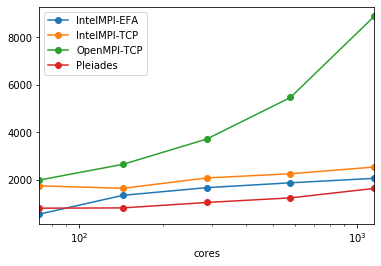

In [19]:
df_cores.plot(marker='o', logx=True)

In [20]:
# scaling with message size
# only select the largest cores
df_mes = dr.sel(cores=1152).min(dim='run').to_pandas().T
df_mes.columns.name = ''
df_mes.tail()

,IntelMPI-EFA,IntelMPI-TCP,OpenMPI-TCP,Pleiades
message,,,,
65536,150.22,515.74,1190.16,97.21
131072,220.46,858.71,1665.82,166.21
262144,302.05,1507.27,2639.47,305.45
524288,684.09,1398.99,7478.70,1581.03
1048576,2059.80,2534.25,8858.59,1635.91


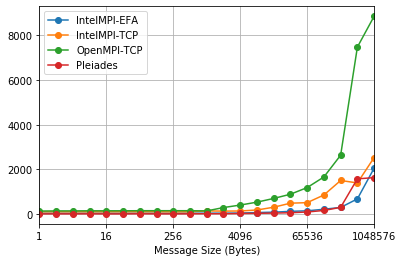

In [21]:
plot_osu(df_mes)

In [22]:
# same for all reduce 
df_ad_cores = dr_ad.sel(message=1048576).min(dim='run').to_pandas().T
df_ad_cores.columns.name = ''
df_ad_cores

,IntelMPI-EFA,IntelMPI-TCP,OpenMPI-TCP,Pleiades
cores,,,,
72,1577.89,1718.83,4108.06,1394.26
144,1530.33,2208.32,5524.52,1414.69
288,1961.03,2880.34,6917.16,1734.79
576,2146.99,3251.91,12144.52,2593.81
1152,3177.14,3928.03,25014.25,3154.71


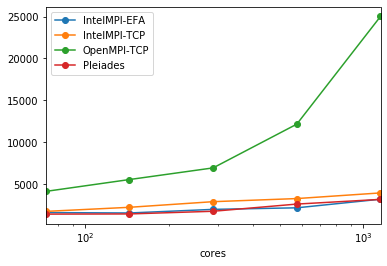

In [23]:
df_ad_cores.plot(marker='o', logx=True)

In [24]:
df_ad_mes = dr_ad.sel(cores=1152).min(dim='run').to_pandas().T
df_ad_mes.columns.name = ''
df_ad_mes.tail()

,IntelMPI-EFA,IntelMPI-TCP,OpenMPI-TCP,Pleiades
message,,,,
65536,681.89,1960.72,13100.37,584.29
131072,782.63,2062.82,13367.73,809.30
262144,949.10,2675.46,13477.00,1348.18
524288,1297.84,2528.79,24956.62,3835.83
1048576,3177.14,3928.03,25014.25,3154.71


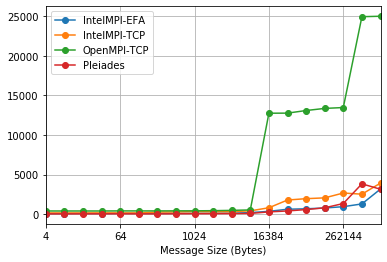

In [25]:
plot_osu(df_ad_mes)

# Polished plots

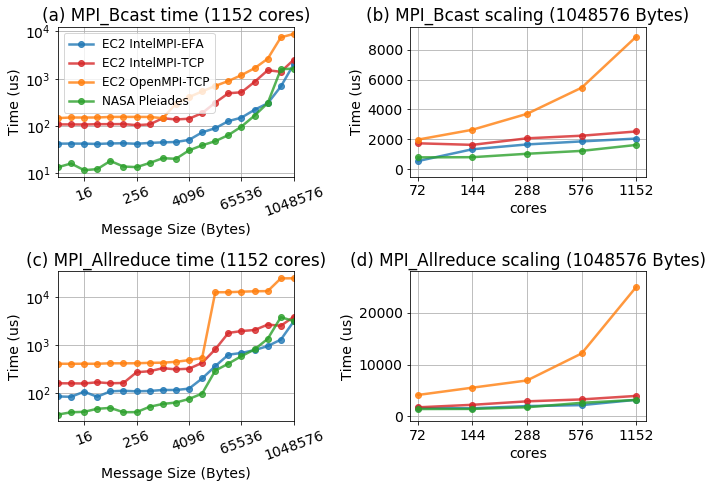

In [26]:
from matplotlib.ticker import ScalarFormatter
plt.rcParams['font.size'] = 14

fig, axes = plt.subplots(2, 2, figsize=[10, 7])

colors = ['C0', 'C3', 'C1', 'C2']
plot_kwargs = dict(color=colors, linewidth=2.5, alpha=0.8)

plot_osu(df_mes[2:], ax=axes[0][0], x_start=2, legend=False, **plot_kwargs, logy=True)
plot_osu(df_ad_mes, ax=axes[1][0], x_start=2, legend=False, **plot_kwargs, logy=True)

df_cores.plot(ax=axes[0][1], marker='o', **plot_kwargs, logx=True, grid=True, legend=False)
df_ad_cores.plot(ax=axes[1][1], marker='o', **plot_kwargs, logx=True, grid=True, legend=False)


axes[0][0].legend(
    labels=['EC2 IntelMPI-EFA', 'EC2 IntelMPI-TCP', 'EC2 OpenMPI-TCP', 'NASA Pleiades'],
    fontsize=12
)


for ax in [axes[0][1], axes[1][1]]:
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.minorticks_off()

    ax.set_xticks(df_cores.index.values)
    ax.set_xlim(65, 1300)
    
axes[0][1].set_ylim(-500, 9500)
axes[1][1].set_ylim(-1000, 28000)

axes[0][0].set_title('(a) MPI_Bcast time (1152 cores)')
axes[1][0].set_title('(c) MPI_Allreduce time (1152 cores)')

axes[0][1].set_title('(b) MPI_Bcast scaling (1048576 Bytes)')
axes[1][1].set_title('(d) MPI_Allreduce scaling (1048576 Bytes)')

for ax in axes.flatten():
    ax.set_ylabel('Time (us)')

for ax in axes[:, 0]:
    ax.tick_params(axis='x', labelrotation=20)  # https://stackoverflow.com/a/54353146
    
fig.tight_layout()

fig.savefig('collectives_compare.png', dpi=300)